In [1]:
#libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import  ticker, cm
import astropy.units as u
from astropy.cosmology import Planck15 as Planck
from astropy.cosmology import z_at_value
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d
import os
# this command prevents Python from multithreading 
os.environ['MKL_NUM_THREADS'] = '1' 
import pandas as pd
import subprocess
from tqdm import tqdm

In [2]:
def mid_creator(bin_array):
    # this function takes as input a set of bin edges (ascending order)
    # and returns as output as array of the mid values
    bin_mid = bin_array[0:len(bin_array)-1]+\
        (bin_array[1:len(bin_array)]-bin_array[0:len(bin_array)-1])/2
    return bin_mid

In [3]:
# paramters that define you star-forming galaxy population

# Redshift array:
# you can choose between 
# 1) 'Equal_z_bins' :equally spaced redshift bins
# 2) 'Equal_t_bins' :equally spaced lookback time bins
# 3) 'min_dt' : you can choose the minimum width of the lookback time bin

bin_type = 'Equal_z_bins' 


if bin_type == 'Equal_z_bins':
    z_a_min = 0 
    z_a_max = 8
    Nz = 50
    z_bin = np.linspace(z_a_max, z_a_min, Nz)

elif bin_type == 'Equal_t_bins': 
    z_a_min = 1e-4 # if Equal_t_bins is enabled z_a_min must different from zero and > 1e-7!
    z_a_max = 8
    Nz = 100
    if z_a_min == 0:
        print('if Equal_t_bins is enabled z_a_min must different from zero and > 1e-7!')
        raise KeyboardInterrupt
    else:
        t_a_max = Planck.lookback_time(z_a_max)
        t_a_min = Planck.lookback_time(z_a_min)
        t_bin = np.linspace(t_a_max, t_a_min, Nz).value
        print('bin edges of time = ', t_bin)
        delta_t = t_bin[1:len(t_bin)]-t_bin[0:len(t_bin)-1]
        print('equal delta t = ', delta_t*1e9)
        z_bin = np.zeros(len(t_bin))
        for i in range(len(z_bin)):
            z_bin[i] = z_at_value(Planck.lookback_time, t_bin[i]*u.Gyr)
        print('z_bin = ', z_bin)
    
elif bin_type == 'min_dt':
    z_a_min = 0
    z_a_max = 8
    max_dt = 0.05 #Gyr
    t_min = 0
    z_bin = []
    z_value = 0
    t_value = t_min
    while z_value < z_a_max:
        t_value = t_value + max_dt
        z_value = z_at_value(Planck.lookback_time, t_value*u.Gyr)
        #print(z_value)
        z_bin.append(z_value)
        
    z_bin = np.concatenate(z_bin, axis = None)[::-1]
    print('number of redshift bins = ', print(len(z_bin)))
    Nz = len(z_bin)
    t_bin = Planck.lookback_time(z_bin)
    print(t_bin)
    
    
# Centers of the redshfit array
z_mid = mid_creator(z_bin)
print('z_mid = ', z_mid)

z_mid =  [7.91836735 7.75510204 7.59183673 7.42857143 7.26530612 7.10204082
 6.93877551 6.7755102  6.6122449  6.44897959 6.28571429 6.12244898
 5.95918367 5.79591837 5.63265306 5.46938776 5.30612245 5.14285714
 4.97959184 4.81632653 4.65306122 4.48979592 4.32653061 4.16326531
 4.         3.83673469 3.67346939 3.51020408 3.34693878 3.18367347
 3.02040816 2.85714286 2.69387755 2.53061224 2.36734694 2.20408163
 2.04081633 1.87755102 1.71428571 1.55102041 1.3877551  1.2244898
 1.06122449 0.89795918 0.73469388 0.57142857 0.40816327 0.24489796
 0.08163265]


In [4]:
# Galaxy mass array
mass_gal_min = 7 #log(Msun)
mass_gal_max = 12 #log(Msun)
Ngal = int(1e03) #Number of mass bins
mass_gal_bin = np.linspace(mass_gal_min, mass_gal_max, Ngal)
# centers of the mass bins
mass_gal_mid = mid_creator(mass_gal_bin)


# GSMF Choice, choose between 'Fontana_2006' or 'Chruslinska_2019' or 'Chruslinska_2019_evol' or 
# 'Conselice_2016' or 'McLeod_2016'. 'Chruslinska_2019' is fiducial model
GSMF_type = 'Chruslinska_2019'


# Number of sampled galaxies at each redshift bin
Nsample = int(1e03) 

# If you want to save the ouput of the current realisation
save_option = 'ON'

#SFR main sequence choice
SFRMR_type = 'Boogaard_2018'

# It is implemented a double gaussian sampling function
# it is going to be used when sampling the SFR per each galaxy from Boco+2020b
Ams = 0.97
Asb = 1-Ams
Asb_save = '1-Ams'
sb_shift = 0.59
sigma_ms = 0.188 #Boco+2020_ sigma_ms = 0.188, Chruslinska value: sigma_ms = 0.3
sigma_sb = 0.243
# SFR binning
SFR_bin = np.linspace(-2, 4, 50)
SFR_mid = mid_creator(SFR_bin)


# Metallicity scaling relation choice
Metallicity_scaling_relation = 'FMR' # choose between 'FMR' or 'MZR'
# MZR choice 
MZR_type = 'Mannucci_2009'
#FMR Choice 
FMR_type = 'Mannucci_2011' # choose between 'Mannucci_2011' or 'Hunt_2016'

# automatically select model name to be in the saved ouput
if Metallicity_scaling_relation == 'MZR':
    met_scaling_rel = MZR_type
elif Metallicity_scaling_relation == 'FMR':
    met_scaling_rel = FMR_type
    
Z_spread_met_rel = 0.15
solar_Z_scale = 'Caffau_11' # other options: 'Asplund_09', 'AndersGrevesse_89','GrevesseSauval_98', 'Villante_14', 'Caffau_11'

# logZ binning
# metallicity array
Z_bin = np.linspace(-6,-1,50)
Z_mid = mid_creator(Z_bin)


# Passive galaxies options 
SFR_min_pass = 0.0001 # or 0.001
SFR_max_pass = 'MS_3sigma' #  or 'MS_2sigma' or 'MS_3sigma'
SFR_dist = 'uniform' # no other option available so far 

# I generally choose Ilbert+2013 because it has a larger redshift span
passive_GSMF_type = 'Ilbert' 


IMF = 'Kroupa_01'

# end of input parameters

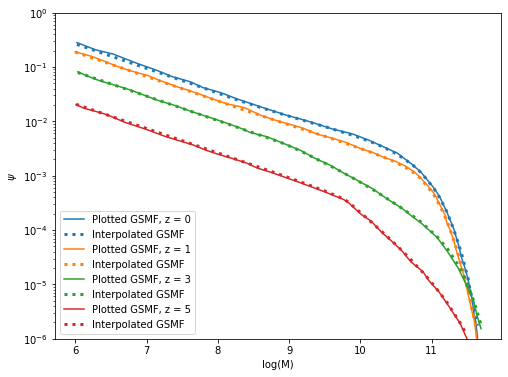

In [5]:
# Cosmlogical scaling relations 
if GSMF_type == 'Fontana_2006':
    # check the IMF
    def GSMF(M,z):
        # galaxy masses are taken in log scale
        def phi_star(z):
            phi_star_0 = 0.0035 # in the original paper we have uncertainties!
            phi_1 = -2.20
            return phi_star_0*(1+z)**phi_1
        def m_star(z):
            m_star_0 = 11.16
            m_star_1 = 0.17
            m_star_2 = -0.07
        return m_star_0+m_star_1*z+m_star_2*z**2
        def alpha_star(z):
            alpha_star_0 = -1.18
            alpha_1 = -0.082
            return alpha_star_0+alpha_1*z
        return phi_star(z)*np.log(10)*(10**(M - m_star(z)))**(1 + alpha_star(z))*np.exp(-10**(M - m_star(z)))

elif GSMF_type == 'Chruslinska_2019':
    # this is defined as a Kroupa IMF: our standard
    GSMG_Chruslinska2019_param = np.loadtxt('Chruslinska2019_GSMF/GSMF_data_lowM_fixed.dat', unpack = True)
    # Here I have a grid of redshift and masses, for z >= 9.184 I have a different number of mass bins
    boo = GSMG_Chruslinska2019_param[2,:] < 9.184
    z_array = np.unique(GSMG_Chruslinska2019_param[2,boo])
    #print(z_chru)
    mass_array = np.unique(GSMG_Chruslinska2019_param[0,boo])
    #print(mass_chru)
    #print(len(z_chru)*len(mass_chru))
    gsmf_array = np.zeros((len(z_array),len(mass_array)))
    counter = 0
    for g in range(len(z_array)):
        for f in range(len(mass_array)):
            #print(GSMG_Chruslinska2019_param[1,counter])
            gsmf_array[g,f] = 10**GSMG_Chruslinska2019_param[1,counter]
            counter = counter + 1
            #print(counter)       
    #print(gsmf_array.ndim)
    GSMF = interp2d(mass_array, z_array, gsmf_array)
    # Comparison of interpolated GSMFs and plotted one.
    z_comp = [0,1,3,5]
    plt.figure(figsize = (8,6))
    for i in range(len(z_comp)):
        #print('z_comp = ', z_comp[i])
        Chru_GSMF = np.loadtxt('Chruslinska2019_GSMF/Chruslinska2019_GSMF__'+str(i)+'.csv', delimiter = ',', unpack = True)
        p = plt.plot(Chru_GSMF[0], 10**Chru_GSMF[1], label = 'Plotted GSMF, z = '+str(z_comp[i]))
        col = p[0].get_color()
        #plt.plot(Chru_GSMF[0], GSMF_Fontana2006(Chru_GSMF[0],z_chru[i]), 
        #     color = col, linestyle = '--', label = 'Fontana')
        plt.plot(Chru_GSMF[0], GSMF(Chru_GSMF[0],z_comp[i]), 
             color = col, linestyle = ':', label = 'Interpolated GSMF', linewidth = 3)
    
    plt.ylabel(r'$\psi$')
    plt.yscale('log')
    plt.ylim(bottom = 1e-6, top = 1e0)
    plt.xlabel('log(M)')    
    plt.legend()    
    plt.savefig('Chruslinska2019_GSMF/Chruslisnka_2019_GSMF_comparison.pdf', format = 'pdf', bbox_inches='tight')
    plt.show()
    
elif GSMF_type == 'Chruslinska_2019_evol':
    # this is defined as a Kroupa IMF: our standard
    GSMG_Chruslinska2019_param = np.loadtxt('Chruslinska2019_GSMF/GSMF_data_lowM_evolving.dat', unpack = True)
    # Here I have a grid of redshift and masses, for z >= 9.184 I have a different number of mass bins
    boo = GSMG_Chruslinska2019_param[2,:] < 9.184
    z_array = np.unique(GSMG_Chruslinska2019_param[2,boo])
    #print(z_chru)
    mass_array = np.unique(GSMG_Chruslinska2019_param[0,boo])
    #print(mass_chru)
    #print(len(z_chru)*len(mass_chru))
    gsmf_array = np.zeros((len(z_array),len(mass_array)))
    counter = 0
    for g in range(len(z_array)):
        for f in range(len(mass_array)):
            #print(GSMG_Chruslinska2019_param[1,counter])
            gsmf_array[g,f] = 10**GSMG_Chruslinska2019_param[1,counter]
            counter = counter + 1
            #print(counter)       
    #print(gsmf_array.ndim)
    GSMF = interp2d(mass_array, z_array, gsmf_array)    
    
elif GSMF_type == 'Conselice_2016':
    # check the IMF
    [z_min, z_max, 
        alpha, dalpha_max, dalpha_min,
        logMstar, dlogMstar_max, dlogMstar_min, 
        psi_star, dpsi_star_max, dpsi_star_min] = np.loadtxt('Conselice2016_GSMF/conselice.txt', 
                                                          skiprows = 1, 
                                                          usecols = np.arange(0,11,1), unpack = True)
    z_conselice_mid = z_min + (z_max-z_min)/2
    # psi_star must be brought to its original scale
    psi_star = psi_star*1e-4
    dpsi_star_max = dpsi_star_max*1e-4
    dpsi_star_min = dpsi_star_min*1e-4
    
    # let's choose the maximum error and to set small errors instead of zero
    d_alpha = np.zeros(len(alpha))
    d_logMstar = np.zeros(len(alpha))
    d_psi_star = np.zeros(len(alpha))
    for t in range(len(alpha)):
        d_alpha[t] = max(dalpha_max[t], dalpha_min[t])
        if d_alpha[t] == 0:
            d_alpha[t] = 1e-5
        d_logMstar[t] = max(dlogMstar_max[t], dlogMstar_min[t])
        if d_logMstar[t] == 0:
            d_logMstar[t] = 1e-5
        d_psi_star[t] = max(dpsi_star_max[t], dpsi_star_min[t])
        if d_psi_star[t] == 0:
            d_psi_star[t] = 1e-10
        
    #print(d_alpha)
    #print(d_logMstar)
    #print(d_psi_star)
    
    z_conselice = np.arange(0,7,0.01)
    #print(z_conselice.shape)
    #print(z_conselice)
    alpha_c = np.zeros(len(z_conselice))
    logMstar_c = np.zeros(len(z_conselice))
    psi_star_c = np.zeros(len(z_conselice))
    
    mass_conselice = np.linspace(6,12,1000)
    #print(mass_conselice.shape)
    #print(mass_conselice)
        
    gsmf_conselice = np.zeros((len(z_conselice),len(mass_conselice)))
    
    for x in range(len(z_conselice)):
        if z_conselice[x] < 0.20:
            z_in = 0.20
            ind_z = z_min == z_in
        else:
            ind_z = (z_conselice[x] < z_max) & (z_conselice[x] >= z_min)
        
        #ind_z = np.argmin(abs(z_conselice[x]-z_conselice_mid))
        
        # arithmetic average
        alpha_c[x] = np.average(alpha[ind_z])
        logMstar_c[x] = np.average(logMstar[ind_z])
        psi_star_c[x] = np.average(psi_star[ind_z])
        
        gsmf_conselice[x,:] = psi_star_c[x]*np.log(10)*\
                (10**(mass_conselice-logMstar_c[x]))**(1+alpha_c[x])*\
                np.exp(-10**(mass_conselice-logMstar_c[x]))
        
    # let's interpolate between mass and redshift
    #print(gsmf_conselice.shape)
    #print(gsmf_conselice.ndim)
    GSMF = interp2d(mass_conselice, z_conselice, gsmf_conselice)
    """
    # weighted average considering also uncertainties
    alpha_c = np.average(alpha[ind_z], weights = 1/d_alpha[ind_z]**2)
    logMstar_c = np.average(logMstar[ind_z], weights = 1/d_logMstar[ind_z]**2 )
    psi_star_c = np.average(psi_star[ind_z], weights = 1/d_psi_star[ind_z]**2)
    """
    
    
elif GSMF_type == 'McLeod_2016':
    # check the IMF
    [a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, a11] = \
        [10.55, 0.00, -0.16, 0.12, -1.45, -0.08, -2.43, -0.17, -0.08, -2.94, -0.22]
    Mstar = a1 + a2*z
    alpha1 = a3 + a4*z
    alpha2 = a5 + a6*z
    log_phi1 = a7 + a8*z + a9*z**2
    log_phi2 = a10 + a11*z
    
    phi_star1 = 10**log_phi1
    phi_star2 = 10**log_phi2
    
    # mass must be in log scale 
    phi_M = np.log(10)*np.exp(-10**(mass-Mstar))*10**(mass-Mstar)*\
            (phi_star1*10**((mass-Mstar)*alpha1)+phi_star2*10**((mass-Mstar)*alpha2))
    
    
    
    

In [6]:
if SFRMR_type == 'Speagle_2014':
    
    if IMF == 'Kroupa_01':
        # you don't need to apply any rescaling, it is already defined with Kroupa
        delta_logM = 0
        K_IMF = 1        
    
    def SFRMR(Mstar,z, delta_logM, K_IMF):
        # mass is taken in log scale
        # where t is the age of the Universe in Gyrs
        t = 13.461701658024014 - Planck.lookback_time(z).value
        return (0.84-0.026*t)*Mstar - (6.51-0.11*t) 
        # there are a series of scatters to be added
        
        
elif SFRMR_type  == 'Boogaard_2018':
    
    if IMF == 'Kroupa_01':
        # in this case you need to apply the rescaling
        delta_logM = +0.03
        K_IMF = 1/0.94
                
    def SFRMR(Mstar,z, delta_logM, K_IMF):
        
        # galaxy masses are taken in linear scale
        Mstar_in = 10**(Mstar) #+delta_logM), don't need this
        z0 = 0.55
        M0 = 10**(8.5+delta_logM)
        a = 0.83 #+uncertainty
        b = -0.83 #+uncertainty
        c = 1.74 #+uncertainty and there are also other different parametrizations of this 
                 # (check Chruslinska+2019)
        SFR_val = a*np.log10(Mstar_in/M0)+b+c*np.log10((1+z)/(1+z0)) # log(Msun/yr) #+uncertainty
        
        return np.log10(10**SFR_val*K_IMF)


elif SFRMR_type  == 'Chruslinska_2019':
    
    
    # not sure about this - check email!
    def SFRMR(Mstar,z):
        # galaxy masses are taken in linear scale
        Mstar_in = 10**Mstar
        #z0 = 0.55
        #M0 = 10**8.5
        a = 0.83 #+uncertainty
        b = -0.83 #+uncertainty
        if z <= 1.8:
            c = 2.8
        else:
            c = 1
        #c = 1.74 #+uncertainty and there are also other different parametrizations of this 
                 # (check Chruslinska+2019)
        return a*np.log10(Mstar_in)+b+c*np.log10((1+z))
        #return a*np.log10(Mstar_in/M0)+b+c*np.log10((1+z)/(1+z0)) # log(Msun/yr) #+uncertainty


if Metallicity_scaling_relation == 'FMR':
    
    if FMR_type == 'Mannucci_2010':       
        
        if IMF == 'Kroupa_01':
            # still not clear if rescaling is necessary
            delta_logM = 0
            K_IMF = 1
        
        
        def FMR(m, sfr):
            # galaxy masses are taken in linear scale
            m_man = np.log10(m)-10
            s_man = sfr
            # metallicity returned in FOH scale 
            return 8.90+0.37*m_man-0.14*s_man-0.19*m_man**2 + 0.12*m_man*s_man - 0.054*s_man**2 
   
    elif FMR_type == 'Mannucci_2011':
        
        if IMF == 'Kroupa_01':
            # still not clear if rescaling is necessary
            delta_logM = 0
            K_IMF = 1
                    
        Met_save = FMR_type
        def FMR(gal_mass, sfr, delta_logM, K_IMF):
            # galaxy masses are taken in log scale
            # sfr is taken in log scale
            #mu_32 = np.log10(gal_mass) - 0.32*sfr
            if gal_mass.size > 1:
                mu_32 = gal_mass - 0.32*sfr
                met = np.zeros(len(gal_mass))
                for mm in range(len(met)):
                    #m_man = np.log10(gal_mass[mm])-10
                    m_man = gal_mass[mm]-10
                    s_man = sfr[mm]
                    if mu_32[mm] >= 9.5:
                        met[mm] = 8.90+0.37*m_man-0.14*s_man-0.19*m_man**2 + \
                        0.12*m_man*s_man - 0.054*s_man**2
                    elif mu_32[mm] < 9.5:
                        met[mm] = 8.93 + 0.51*(mu_32[mm] - 10)
            else:
                mu_32 = gal_mass - 0.32*sfr
                #met = np.zeros(gal_mass.size)
                #for mm in range(met):
                    #m_man = np.log10(gal_mass[mm])-10
                m_man = gal_mass-10
                s_man = sfr
                if mu_32 >= 9.5:
                    met = 8.90+0.37*m_man-0.14*s_man-0.19*m_man**2 + \
                        0.12*m_man*s_man - 0.054*s_man**2
                elif mu_32 < 9.5:
                    met = 8.93 + 0.51*(mu_32 - 10)
            # metallicity returned in FOH scale 
            return met

    elif FMR_type == 'Hunt_2016':
        
        if IMF == 'Kroupa_01':
            delta_logM = 0
            K_IMF = 1
        
        Met_save = FMR_type
        def FMR(gal_mass, sfr, delta_logM, K_IMF):
            # galaxy mass and sfr are taken in log scale
            met = -0.14*sfr+0.37*gal_mass+4.82
            return met

        
        
elif Metallicity_scaling_relation == 'MZR':
    if MZR_type == 'Mannucci_2009':
                
        if IMF == 'Kroupa_01':
            # in questo caso devo applicare il rescaling 
            delta_logM = 0
            K_IMF = 1
            
            
        Met_save = MZR_type
        def MZR(M_gal, z_in, delta_logM, K_IMF):
            
            # galaxy mass in linear scale
            z = [0, 0.7, 2.2, 3.5]
            Z_OH_asym_z = [9.08, 9.11, 9.04, 8.72]
            M_TO_z = 10**np.array([9.25, 9.72, 10.46, 10.54])
            gamma_z = [0.63, 0.57, 0.59, 0.60]
            if z_in < 3.5:
                # interpolation over redshift
                Z_OH_asym_interp = interp1d(z,Z_OH_asym_z)
                M_TO_interp = interp1d(z,M_TO_z)
                gamma_interp = interp1d(z,gamma_z)
                Z_OH_asym = Z_OH_asym_interp(z_in)
                M_TO = M_TO_interp(z_in)
                gamma = gamma_interp(z_in)
                return Z_OH_asym - np.log10(1+(M_gal/M_TO)**(-gamma))
            elif z_in >= 3.5:
                rate_dz = -0.26
                log_OH_3_5 = Z_OH_asym_z[3] - np.log10(1+(M_gal/M_TO_z[3])**(-gamma_z[3]))
                return log_OH_3_5 + rate_dz*(z_in - 3.5)
    
def solar_metallicity_scales():
    Asplund09 = [0.0134, 8.69]
    AndersGrevesse89 = [0.017, 8.83]
    GrevesseSauval98 = [0.0201, 8.93]
    Villante14 = [0.019, 8.85]
    Caffau11 = [0.0153, 8.76]
    scale_ref = np.array(['Asplund_09', 'AndersGrevesse_89',
                          'GrevesseSauval_98', 'Villante_14', 'Caffau_11'])
    Z_FOH_solar = np.array(
        [Asplund09, AndersGrevesse89, GrevesseSauval98, Villante14, Caffau11])
    return scale_ref, Z_FOH_solar

def FOH2ZZ(foh,solar_Z_scale):
    '''convert from 12+log[O/H] to ZZ'''
    scale_ref, Z_FOH_solar=solar_metallicity_scales()
    idx=np.where(scale_ref==solar_Z_scale)[0][0]
    Zsun,FOHsun = Z_FOH_solar[idx]
    logZ = np.log10(Zsun) + foh - FOHsun
    ZZ=10**logZ
    return ZZ

def SFRMR_2gauss(log_psi_ms_sampled, sb_shift, sigma_ms, sigma_sb, Ams):
    log_psi_sb_sampled = log_psi_ms_sampled + sb_shift
    log_psi_fin = np.zeros(len(log_psi_ms_sampled))
    for i in range(len(log_psi_ms_sampled)):
        gauss1 = np.random.normal(log_psi_ms_sampled[i], sigma_ms)
        gauss2 = np.random.normal(log_psi_sb_sampled[i], sigma_sb)
        coin = np.random.uniform(0,1)
        if coin <= Ams:
            log_psi_fin[i] = gauss1
        elif coin > Ams:
            log_psi_fin[i] = gauss2
    return log_psi_fin

In [7]:
# Saving the sampled values

# freem parameters defined in the above cells
params = [bin_type, z_a_min, z_a_max, Nz, mass_gal_min, mass_gal_max, 
          Ngal, GSMF_type, Nsample, SFRMR_type , Ams,  Asb_save, sb_shift, 
         sigma_ms, sigma_sb, met_scaling_rel ,Z_spread_met_rel, solar_Z_scale,
         SFR_min_pass, SFR_max_pass, SFR_dist, passive_GSMF_type, IMF]

folder_file = '../galaxy_models/galaxy_models_list.csv'

def model_finder(params):
    df = pd.read_csv(folder_file, header = 0)
    variables = df.keys()
    print('variables = ', variables)
    num_of_cases = len(df[variables[0]])
    print('number of cases = ',num_of_cases )
    b = 0
    for y in range(num_of_cases):
        if b == 0:
            index = y+1
            summing = 0
            #print('y = ', y+1)
            #print('    ',' all ', '   this case')
            for i in range(len(params)):
                print('    ',df[variables[i+1]][y], params[i])
                if df[variables[i+1]][y] == params[i]:
                    summing = summing + 1
                    #print(summing)
                if summing == len(params):
                    print('        found index ! = M',index)
                    b = 1 
                    break
            if (b == 0) and (y == num_of_cases-1):
                print('No index found')
                index = 'No index found'
        elif b == 1:
            break
    return index, num_of_cases

index, num_of_cases = model_finder(params)

if index != 'No index found':
    print('This cosmological configuration already exist. It will be overwritten')
    folder_all = '../galaxy_models/M'+str(index)+'/Tables/'
elif index == 'No index found':
    print('I am creating a new folder M'+str(num_of_cases+1))
    os.system('mkdir ../galaxy_models/M'+str(num_of_cases+1))
    os.system('mkdir ../galaxy_models/M'+str(num_of_cases+1)+'/Tables')
    print('and adding the new model to ',folder_file)
    
    df = pd.read_csv(folder_file, header = 0)
    folder_all = '../galaxy_models/M'+str(num_of_cases+1)+'/Tables/'
    
    params_add = np.concatenate([num_of_cases+1, params], axis = None)
    params_add = params_add.tolist()
    
    print('list of params_add = ', len(params_add))
        
    print(len(df.keys().tolist()))
    
    params_add = pd.DataFrame([params_add], columns=df.keys().tolist())
    
    print('what I am adding = ', params_add)
    
    df_save = df.append(params_add, ignore_index = True)
    
    print('saving frame = ', df_save)
    
    df_save.to_csv(folder_file,index=False)
    


variables =  Index(['ID', 'bin_type ', 'z_a_min ', 'z_a_max ', 'Nz    ',
       'log_mass_gal_min ', 'log_mass_gal_max  ', 'Ngal ', 'GSMF_type',
       ' Nsample   ', ' SFMR_type', 'Ams', ' Asb ', '  sb_shift  ',
       'sigma_ms    ', 'sigma_sb  ', 'met_rel_type   ', 'Z_spread_met_rel ',
       'solar_Z_scale ', 'SFR_min_passive', 'SFR_max_passive',
       'SFR_dist_passive', 'GSMF_pass', 'IMF'],
      dtype='object')
number of cases =  1
     Equal_z_bins Equal_z_bins
     0 0
     8 8
     50 50
     7 7
     12 12
     1000 1000
     Chruslinska_2019 Chruslinska_2019
     1000 1000
     Boogaard_2018 Boogaard_2018
     0.97 0.97
     1-Ams 1-Ams
     0.59 0.59
     0.188 0.188
     0.243 0.243
     Mannucci_2011 Mannucci_2011
     0.15 0.15
     Caffau_11 Caffau_11
     0.0001 0.0001
     MS_3sigma MS_3sigma
     uniform uniform
     Ilbert Ilbert
     Kroupa_01 Kroupa_01
        found index ! = M 1
This cosmological configuration already exist. It will be overwritten


100%|███████████████████████████████████████████| 49/49 [00:01<00:00, 46.86it/s]


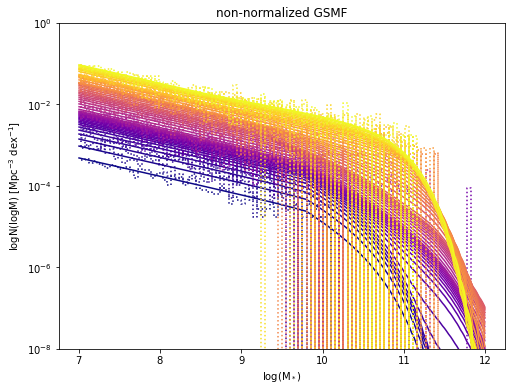

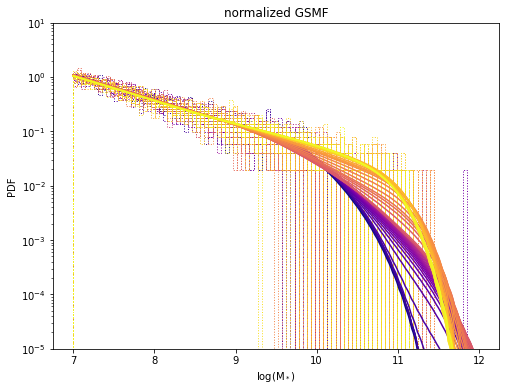

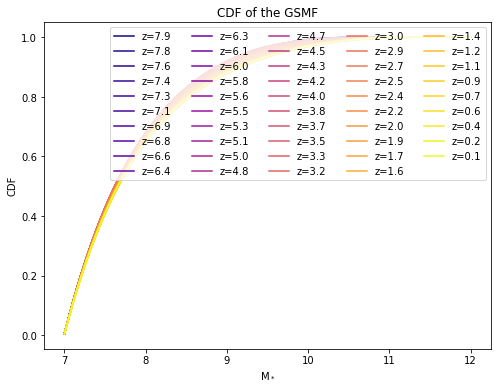

In [8]:
# Sampling galaxy masses and assign SFR and Z at each sampled galaxy

# saving the sampled SFR and metallicity value
SFR_all = np.zeros((len(z_mid),Nsample))
Z_all = np.zeros((len(z_mid), Nsample))
FOH_all = np.zeros((len(z_mid), Nsample))
Mass_all = np.zeros((len(z_mid), Nsample))
N_mass_sampled = np.zeros((len(z_mid), len(mass_gal_mid)))

# creating various figures:
f0 = plt.figure(figsize = (8,6))
ax0 = f0.add_subplot(111)
# normed GSMF and sampled masses
f1 = plt.figure(figsize = (8,6))
ax1 = f1.add_subplot(111)
# CDF of the GSMF
f2 = plt.figure(figsize = (8,6))
ax2 = f2.add_subplot(111)

# color map
viridis = cm.get_cmap('plasma', len(z_mid))
divid = np.linspace(0, 1, len(z_mid))
color_z = viridis(divid)

# integration constant is important for assign the volume element at each redshift
dN_dV = np.zeros(len(z_mid))

### bin width in log-scale
DeltaMj = mass_gal_bin[1:len(mass_gal_bin)]-mass_gal_bin[0:len(mass_gal_bin)-1]

mass_bins_plot = np.linspace(mass_gal_min, mass_gal_max, int(Nsample/10))

mass_bins_plot_mid = mid_creator(mass_bins_plot)

# loop over redshift from the highest to the lowest 
for i in tqdm(range(len(z_mid))):
    ax0.plot(mass_gal_mid, GSMF(mass_gal_mid,z_mid[i]), color = color_z[i],
            label = 'z='+str(round(z_mid[i],1)))
    
    ### evaluating the integration constant
    ### integration contant over the mass spectrum    
    dN_dV[i] = np.sum(GSMF(mass_gal_mid,z_mid[i])*DeltaMj) 
              
    #print('z = ',z_mid[i], ' dN/dV = ',dN_dV[i])
    
    # I checked if I was making a mistake in the integration procces, apparently no
    #dN_dV_simps[i] = simps(GSMF(mass_gal_mid,z_mid[i]),mass_gal_mid)
    #print('z = ',z_mid[i], ' dN/dV simps = ',dN_dV[i])
    
    n_deltaMj = GSMF(mass_gal_mid,z_mid[i])/dN_dV[i]
    ax1.plot(mass_gal_mid, n_deltaMj, color = color_z[i],
             label = 'z='+str(round(z_mid[i],1))) 
    
    ### evaluating the CDF of the GSMF and plotting it 
    CDF_GSMF = np.cumsum(n_deltaMj*DeltaMj) 
    ax2.plot(mass_gal_mid, CDF_GSMF,color = color_z[i],
             label = 'z='+str(round(z_mid[i],1)))
    
    ### drawning Nsample random numbers
    coins = np.random.uniform(CDF_GSMF.min(),CDF_GSMF.max(),Nsample)
    inv_CDF = interp1d(CDF_GSMF, mass_gal_mid)
    mass_sampled = np.sort(inv_CDF(coins))
    Mass_all[i,:] = mass_sampled
    
    ax1.hist(mass_sampled, mass_bins_plot, 
             histtype = 'step', density = True, color = color_z[i], linestyle = ':') 
    ### We want to check the normalization constant, i.e. the number of galaxy 
    ### per volume element. We plot this instogram against the GSMF
    check_const = np.histogram(mass_sampled, bins = mass_bins_plot,
                               density = True)[0]*dN_dV[i]
    N_mass_sampled[i,:] =  np.histogram(mass_sampled, bins = mass_gal_bin)[0]
    ax0.step(mass_bins_plot_mid, check_const, color = color_z[i],
            linestyle = ':')
    
    ### evaluating the SFR for each given galaxy
    ### we are adopting the double-gaussian.
    log_psi_ms_sampled = SFRMR(mass_sampled,z_mid[i],delta_logM, K_IMF)
    SFR_all[i,:] = SFRMR_2gauss(log_psi_ms_sampled, sb_shift, sigma_ms, sigma_sb, Ams)
        
    ### evaluating the metallicity of each given galaxy 
    if Metallicity_scaling_relation == 'FMR':
        FOH_sampled = FMR(Mass_all[i,:], SFR_all[i,:], delta_logM, K_IMF)
        FOH_all[i,:] = FOH_sampled # without scatter
        ### converting in metallcity values
        Z_mean_sampled = np.log10(FOH2ZZ(FOH_all[i,:],solar_Z_scale))
        Z_sampled = np.random.normal(Z_mean_sampled, 0.15)
        ### you have to think more about this scatter
        Z_all[i, :] = Z_sampled
    elif Metallicity_scaling_relation == 'MZR':
        FOH_sampled = MZR(10**Mass_all[i,:], z_mid[i], delta_logM, K_IMF)
        FOH_all[i,:] = FOH_sampled # without scatter
        ### converting in metallcity values
        Z_mean_sampled = np.log10(FOH2ZZ(FOH_all[i,:],solar_Z_scale))
        Z_sampled = np.random.normal(Z_mean_sampled, 
                                     Z_spread_met_rel)
        ### you have to think more about this scatter
        Z_all[i, :] = Z_sampled
        


if save_option == 'ON':
    np.savetxt(folder_all+'logM.txt',Mass_all,
           header = 'Sampled logM')
    np.savetxt(folder_all+'logSFR.txt',SFR_all,
           header = 'Sampled logSFR')
    np.savetxt(folder_all+'logZ.txt',Z_all,
           header = 'Sampled logZ')
    np.savetxt(folder_all+'Redshift_bins_edges.txt',z_bin,
           header = 'Redshift')
    np.savetxt(folder_all+'dN_dV.txt',np.transpose([z_mid,dN_dV]),
           header = 'redshift    dN_dV [Mpc^{-3}]')

# various figure features
### non-normalized GSMF
ax0.set_title('non-normalized GSMF')
ax0.set_yscale('log')
ax0.set_xlabel(r'log(M$_*$)')
ax0.set_ylabel(r'logN(logM) [Mpc$^{-3}$ dex$^{-1}$]')
ax0.set_ylim(bottom= 1e-8, top = 1)
#ax0.legend(ncol = 5)
if save_option == 'ON':
    ax0.figure.savefig(folder_all+'non_normalizedGSMF.pdf', format = 'pdf', bbox_inches='tight')
### normalized GSMF
ax1.set_title('normalized GSMF')
ax1.set_yscale('log')
ax1.set_xlabel(r'log(M$_*$)')
ax1.set_ylabel(r'PDF')
ax1.set_ylim([1e-5,1e01])
#ax1.legend(ncol = 5)
if save_option == 'ON':
    ax1.figure.savefig(folder_all+'normalizedGSMF.pdf', format = 'pdf', bbox_inches='tight')
### CDF
ax2.set_title('CDF of the GSMF')
ax2.set_xlabel(r'M$_*$')
ax2.set_ylabel(r'CDF')
ax2.legend(loc = 1, ncol = 5)
if save_option == 'ON':
    ax2.figure.savefig(folder_all+'GSMF_CDF.pdf', format = 'pdf', bbox_inches='tight')

plt.show()

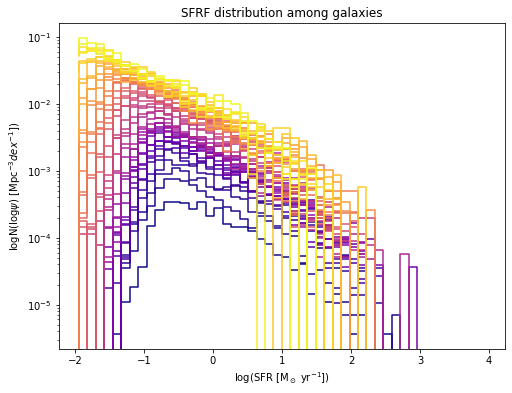

In [9]:
### distribution of star formation rate at each given redshift
SFRD_z = np.zeros(len(z_mid)) # This will be the SFRD evaluated simply with the mean

SFRD_z2 = np.zeros(len(z_mid)) # This will be the SFRD evaluated simply with the mean

# distribution of SFR among galaxies and volume
SFRF = np.zeros((len(z_mid),len(SFR_mid)))


f3 = plt.figure(figsize = (8,6))
ax3 = f3.add_subplot(111)
# loop over redshift from the highest to the lowest 
for i in range(len(z_mid)):
    SFRF[i,:] = np.histogram(SFR_all[i,:], bins = SFR_bin, 
                             density = True)[0]*dN_dV[i]
    ax3.step(SFR_mid, SFRF[i,:], color = color_z[i])#, label = 'z='+str(round(z_mid[i],1)))
    # evaluating the mean SFR times dN/dV
    SFRD_z[i] = np.mean(10**SFR_all[i,:])*dN_dV[i]  
    
np.savetxt(folder_all+'SFRD_from_samples.txt', np.transpose([z_mid,SFRD_z]), 
           header = 'redshift    SFRD [Msun/yr/Mpc^3]')

### SFR 
ax3.set_title('SFRF distribution among galaxies')
ax3.set_yscale('log')
#ax3.set_xscale('log')
ax3.set_xlabel(r'log(SFR [M$_\odot$ yr$^{-1}$])')
ax3.set_ylabel(r'logN(log$\psi$) [Mpc$^{-3}dex^{-1}$])')
#ax3.legend()
if save_option == 'ON':
    plt.savefig(folder_all+'SFRF.pdf', format = 'pdf', bbox_inches='tight')
plt.show()


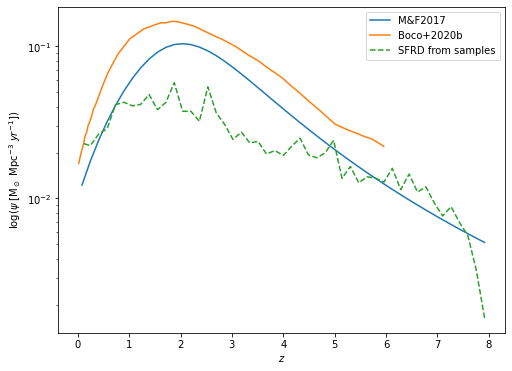

In [10]:
# SFRD comparison
def SFR_madau(zf):
    sfrd = 0.01*(1 + zf)**(2.6)/(1+((1 + zf)/3.2)**(6.2))
    return sfrd

Boco_plotted = np.loadtxt('Boco21_SFRD.csv', delimiter = ',')

plt.figure(figsize = (8,6))   
plt.plot(z_mid, SFR_madau(z_mid), label = 'M&F2017')
plt.plot(Boco_plotted[:,0], 10**Boco_plotted[:,1], label = 'Boco+2020b')
plt.plot(z_mid, SFRD_z, label = 'SFRD from samples', linestyle = '--')
plt.xlabel(r'$z$')
plt.ylabel(r'log($\psi$ [M$_\odot$ Mpc$^{-3}$ $yr^{-1}$])')
plt.yscale('log')
plt.legend()
if save_option == 'ON':
    plt.savefig(folder_all+'SFRD_comparison.pdf', format = 'pdf',bbox_inches='tight' )
plt.show() 

Zsun =  0.0153


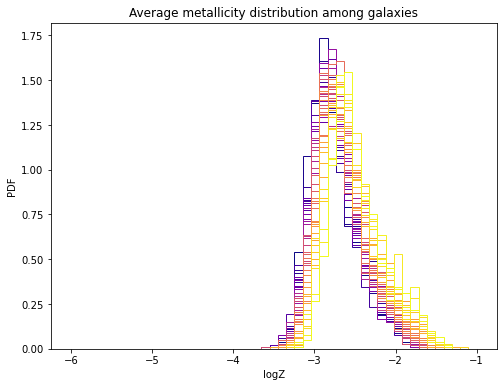

In [11]:
### Metallicity comparison
#Zsun = 0.0153 # From Caffau et al. 2011
solar_Z_scale
all_Zsun_scales, Zsun_values = solar_metallicity_scales()
ind_Zsun = solar_Z_scale == all_Zsun_scales
Zsun = Zsun_values[ind_Zsun][0][0]
print('Zsun = ', Zsun)


def DeCia(zf):
    intercept = np.log10(1.04)
    slope = -0.24
    Z = intercept+slope*zf
    return Z

def MandF2017(zf):
    intercept = 0.153
    slope = -0.074
    Z = intercept+slope*zf**(1.34)
    return Z

### metallicity value at each given redshift
Z_z_weighted_sfr = np.zeros(len(z_mid))
Z_z_weighted_log = np.zeros(len(z_mid))
Z_z_weighted_nonlog = np.zeros(len(z_mid))
Z_z_nonweighted = np.zeros(len(z_mid))
Z_z_50 = np.zeros(len(z_mid))
#Z_z_05 = np.zeros(len(z_mid))
#Z_z_95 = np.zeros(len(z_mid))

### metallicity distribution
f4 = plt.figure(figsize = (8,6))
ax4 = f4.add_subplot(111)

### loop over redshift from the highest to the lowest 
for i in range(len(z_mid)):
    #print(Mass_all[i,:])
    Z_z_weighted_sfr[i] = np.average(Z_all[i,:], weights = 10**SFR_all[i,:])
    Z_z_weighted_log[i] = np.average(Z_all[i,:], weights = Mass_all[i,:])
    Z_z_weighted_nonlog[i] = np.average(Z_all[i,:], weights = 10**Mass_all[i,:])
    Z_z_nonweighted[i] = np.average(Z_all[i,:])
    Z_z_50[i] = np.percentile(Z_all[i,:],50)
#    Z_z_05[i] = np.percentile(10**Z_all[i,:],25)
#    Z_z_95[i] = np.percentile(10**Z_all[i,:],75)
    ax4.hist(Z_all[i,:], bins = Z_bin, 
             histtype = 'step', label = 'z='+str(round(z_mid[i],1)), 
             color = color_z[i], density = True) 

### Metallicity
ax4.set_title('Average metallicity distribution among galaxies')
#ax4.set_yscale('log')
#ax4.set_xscale('log')
ax4.set_xlabel(r'logZ')
ax4.set_ylabel(r'PDF')
#ax4.legend()
if save_option == 'ON':
    plt.savefig(folder_all+'Z_distribution.pdf', format = 'pdf',bbox_inches='tight' )


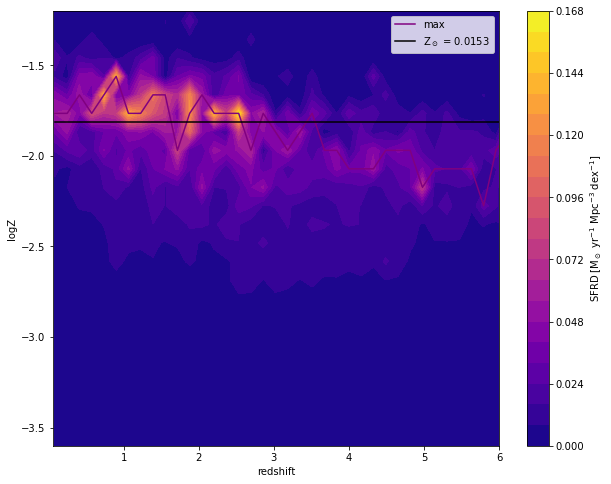

In [12]:
# distirbution of SFRD across metallicities and redshift
Delta_Z = Z_bin[1:len(Z_bin)]-Z_bin[0:len(Z_bin)-1]

SFRD_Chruslisnka_Zz = np.zeros((len(z_mid),len(Z_mid)))

plt.close()
plt.figure(figsize = (10,8))
for i in range(len(z_mid)):
    [dP_dlogM_dZ, x_edges, y_edges] = np.histogram2d(Mass_all[i,:], 
            Z_all[i,:],bins = [mass_gal_bin, Z_bin], density = True)
    ind_z = np.digitize(Z_all[i,:], Z_bin, right = True)
    N_Z_sample = len(ind_z)
    if len(np.argwhere(ind_z == 0)) != 0:
        print('out')
    count = 0
    N_Z = np.zeros(len(Z_mid))
    dN_dV_dZ = np.zeros(len(Z_mid))
    for y in range(1,len(Z_mid)+1):
        dN_dV_dZ[y-1] = np.sum(dP_dlogM_dZ[:,y-1]*DeltaMj)*dN_dV[i]
        ind_sfr = np.argwhere(ind_z == y)
        """
        # This loop was implemented to check whether np.digitize was actually working
        for k in range(len(ind_sfr)):
            if (Z_all[i,ind_sfr[k]] > Z_bin[y]) or (Z_all[i,ind_sfr[k]] < Z_bin[y-1]):
                print('problem', Z_all[i,ind_sfr[k]],'Z[y] = ', Z_bin[y],
                      'Z[y-1] = ',Z_bin[y-1])
                break
        print('logZ = ',Z_mid[y],'number of elements = ',len(ind_sfr))
        """
        count = count + len(ind_sfr)
        N_Z[y-1] = len(ind_sfr)
        if len(ind_sfr) == 0:
            SFRD_Chruslisnka_Zz[i,y-1] = 0
        else:
            insert_sfr = 10**SFR_all[i,ind_sfr]
            SFRD_Chruslisnka_Zz[i,y-1] = np.mean(insert_sfr)*dN_dV_dZ[y-1]
            

    if abs(np.sum(dN_dV_dZ*Delta_Z)-dN_dV[i]) > 1e-5:
        print('trouble', np.sum(dN_dV_dZ*Delta_Z))

    summed_SFRD = np.sum(SFRD_Chruslisnka_Zz[i,:]*Delta_Z)
    if abs(summed_SFRD - SFRD_z[i]) > 1e-5:
        print('there is a problem')
        print('summed_SFRD = ', summed_SFRD)
        print('correct SFRD = ',SFRD_z[i])
    


SFRD_max_at_Z = np.zeros(len(z_mid))
for z in range(len(z_mid)):
    SFRD_max_at_Z[z] = Z_mid[np.argwhere(SFRD_Chruslisnka_Zz[z,:] == 
                                         max(SFRD_Chruslisnka_Zz[z,:]))]
plt.plot(z_mid, SFRD_max_at_Z, label = 'max', color = 'purple')
plt.contourf(z_mid,Z_mid, np.transpose(SFRD_Chruslisnka_Zz), levels = 20, cmap = 'plasma') 
#plt.plot(SFRD_max_at_z_pdf, SFRD_max_at_Z_pdf, label = 'max with PDF method',
#         color = 'purple', linewidth = 2.5, linestyle = '--')
plt.plot(z_mid, np.log10(Zsun)*np.ones(len(z_mid)), color = 'black', label = r'Z$_\odot$ = '+str(Zsun))
plt.xlabel(r'redshift')
plt.ylabel(r'logZ')
plt.colorbar(label = 'SFRD [M$_\odot$ yr$^{-1}$ Mpc$^{-3}$ dex$^{-1}$]')
plt.ylim([-3.6,-1.2])
plt.xlim([0.05,6])
plt.legend()
if save_option == 'ON':
    plt.savefig(folder_all+'SFRD_zZ.pdf', format = 'pdf',bbox_inches='tight' )
#else:
#    plt.savefig('SFRD_zZ.pdf', format = 'pdf',bbox_inches='tight' )
plt.show() 
    

In [13]:
#plt.close()
plt.figure(figsize = (8,6))
plt.plot(z_mid, SFRD_max_at_Z, label = 'max', color = 'black')

from scipy.signal import savgol_filter
yhat = savgol_filter(SFRD_max_at_Z, 31, 3)
#SFRD_max_at_Z_interp = interp1d(z_mid, SFRD_max_at_Z)


plt.plot(z_mid, yhat, label = 'max filtered', color = 'black', linestyle = '--')

np.savetxt(folder_all+'maxSFRD_at_Z.txt',np.transpose([z_mid, yhat]),
           header = 'z    maxSFRD at Z')


plt.plot(z_mid, Z_z_weighted_sfr, label = 'sfr-weighted average', color = 'purple')
plt.plot(z_mid, Z_z_weighted_nonlog, label = 'weighted average', color = 'green')
plt.plot(z_mid, Z_z_weighted_log, label = 'log weighted average', color = 'green', linestyle = '--')
plt.plot(z_mid, Z_z_nonweighted, label = 'non-weighted average', color = 'red')
plt.plot(z_mid, Z_z_50, label = 'median', color = 'orange')
#plt.fill_between(z_mid, np.log10(Z_z_05/Zsun), np.log10(Z_z_95/Zsun), label = '50% credible interval', color = 'orange', alpha = 0.5)
plt.plot(z_mid, DeCia(z_mid)+np.log10(Zsun), label = 'DeCia')
plt.plot(z_mid, MandF2017(z_mid)+np.log10(Zsun), label = 'MandF2017')
plt.xlabel('z - redshift')
plt.ylabel(r'log(Z)')
plt.legend()
if save_option == 'ON':
    plt.savefig(folder_all+'Z_comparison.pdf', format = 'pdf',bbox_inches='tight' )
else:
    plt.savefig('Z_comparison.pdf', format = 'pdf',bbox_inches='tight')
plt.show()

In [14]:
# passive galaxies
# passive GSMF from Ilbert et al. 2013 or McLeod+2021

# passive galaxies are well represented by a double-Schechter
def GSMF_double(M_in, z_in, M_star_in, phi_1_in, alpha_1_in, phi_2_in,alpha_2_in):
    # where M_in is in log scale
    z_ind = np.digitize(z_in, z_min_Ilbert)-1
    #print('chosen index = ', z_ind)
    return np.log(10)*np.exp(-10**(M_in-M_star_in[z_ind]))*\
        10**(M_in-M_star_in[z_ind])*\
        (phi_1_in[z_ind]*10**((M_in-M_star_in[z_ind])*alpha_1_in[z_ind])\
        + phi_2_in[z_ind]*10**((M_in-M_star_in[z_ind])*alpha_2_in[z_ind]))


# here I am defining the GSMF
if passive_GSMF_type == 'Ilbert':
    # I added here redshift zero to be equal to z = 0.2
    # redshift arrays:
    z_min_Ilbert = np.array([0,0.2, 0.5, 0.8, 1.1, 1.5, 2.0, 2.5])
    z_max_Ilbert = np.array([0.2,0.5, 0.8, 1.1, 1.5, 2.0, 2.5, 3.0])
    z_Ilbert = z_min_Ilbert+(z_max_Ilbert-z_min_Ilbert)/2
    print('redshift array  from Ilbert+2013 = ', z_Ilbert)
    # passive
    log_Mstar_qui = np.array([10.91, 10.91, 10.93, 10.81, 10.72, 10.73, 10.59, 10.27])
    phi_star1_qui= np.array([1.27,1.27, 1.11, 1.57, 0.70, 0.22, 0.10, 0.003])*1e-3
    alpha_1_qui = [-0.68, -0.68, -0.46, -0.11, 0.04, 0.10, 0.88, 3.26]
    phi_star2_qui = np.array([0.03,0.03, 0, 0, 0, 0, 0, 0])*1e-3
    alpha_2_qui = [-1.52,-1.52, 0, 0, 0, 0, 0, 0]
    # full
    log_Mstar_full = np.array([10.88, 11.03, 10.87, 10.71, 10.74, 10.74, 10.76, 10.74])
    phi_star1_full = np.array([1.68, 1.22, 2.03, 1.35, 0.88, 0.62, 0.26, 0.03])*1e-3
    alpha_1_full = [-0.69, -1.00, -0.52, -0.08, -0.24, -0.22, -0.15, 0.95]
    phi_star2_full = np.array([0.77, 0.16, 0.29, 0.67, 0.33, 0.15, 0.14, 0.09])*1e-3
    alpha_2_full = [-1.42, -1.64, -1.62, -1.46, -1.6, -1.6, -1.6, -1.6]
    
elif passive_GSMF_type == 'McLeod':
    z_min_McLeod = [0 , 0.25, 0.75, 1.25, 1.75, 2.25, 2.75]
    z_max_McLeod = [0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.75]
    



redshift array  from Ilbert+2013 =  [0.1  0.35 0.65 0.95 1.3  1.75 2.25 2.75]


In [15]:
# let's define the array of masses
masses_NSFR = np.linspace(mass_gal_min,12,500)
mass_bins_plot = np.linspace(mass_gal_min, 12, 500)
mass_bins_plot_mid = mid_creator(mass_bins_plot)
masses_NSFR_delta = masses_NSFR[1:len(masses_NSFR)]-masses_NSFR[0:len(masses_NSFR)-1]
masses_NSFR_mid = masses_NSFR[0:len(masses_NSFR)-1]+masses_NSFR_delta/2

GSMF_NSFR = np.zeros((len(z_Ilbert), len(masses_NSFR)))
GSMF_tot = np.zeros((len(z_Ilbert), len(masses_NSFR)))

for t in range(len(z_Ilbert)):
    GSMF_NSFR[t,:] = GSMF_double(masses_NSFR, z_Ilbert[t],
            log_Mstar_qui, phi_star1_qui, alpha_1_qui ,
            phi_star2_qui, alpha_2_qui)
    GSMF_tot[t,:] = GSMF_double(masses_NSFR, z_Ilbert[t],
            log_Mstar_full, phi_star1_full, alpha_1_full,
            phi_star2_full, alpha_2_full)
    
# in this way I can define the GSMF at redshift zero in the interpolation 
GSMF_NSFR_interp = interp2d(masses_NSFR,z_min_Ilbert,GSMF_NSFR)
GSMF_tot_interp = interp2d(masses_NSFR,z_min_Ilbert,GSMF_tot)

In [16]:
# passive galaxies 
if (SFR_min_pass == 'least_SF_EAGLE') and (SFR_max_pass == 'least_SF_MS'):
    print("I don't need to sample passive galaxies. Exit the code")
    passive_calc = False
else:
    mass_bin_for_sfr = np.logspace(7,12,100)
    mass_bin_for_sfr_mid = mid_creator(mass_bin_for_sfr )
    
    
    SFR_pass_min =  float(SFR_min_pass)

    avg_pass_SFR = np.zeros((len(z_mid),len(mass_bin_for_sfr)-1))
    std_pass_SFR = np.zeros((len(z_mid),len(mass_bin_for_sfr)-1))
    SFR_pass_max = np.zeros((len(z_mid),len(mass_bin_for_sfr)-1))
    SFR_pass_min = np.ones((len(z_mid),len(mass_bin_for_sfr)-1))*SFR_pass_min


    ind_max = np.argmax(dN_dV)
    V = Nsample/dN_dV[ind_max]

    print('considered Volume length = ', V**(1/3), ' Mpc')
    
    
    if SFR_max_pass == 'MS_2sigma':
        nsigma_max = 2
    elif SFR_max_pass == 'MS_3sigma':
        nsigma_max = 3
        

    for i in range(len(z_mid)):
        #print('z = ', z_mid[i])
        for n in range(len(mass_bin_for_sfr)-1):
            #print('    logM = ', round(np.log10(mass_bin_for_sfr_mid[n]),2))
            avg_pass_SFR[i,n] = SFRMR(np.log10(mass_bin_for_sfr_mid[n]),z_mid[i], delta_logM, K_IMF)
            #print('        average logSFR = ', round(avg_pass_SFR[i,n],2))
            std_pass_SFR[i,n] = sigma_ms
            
            SFR_pass_max[i,n] = avg_pass_SFR[i,n] - nsigma_max*std_pass_SFR[i,n]
            #print('        max logSFR = ', round(SFR_max[i,n],2))

    # let's check if the Passive folder exists 
    # otherwise I create it 
    folder_all_in_pass = folder_all + 'Passive/'

    print('I check if the Passive folder exists:', 
          folder_all_in_pass)

    check_folder = os.path.isdir(folder_all_in_pass)

    if check_folder == False:
        print('creating folder')
        os.mkdir(folder_all + 'Passive/')

    passive_calc = True
        

considered Volume length =  22.438303853966616  Mpc
I check if the Passive folder exists: ../galaxy_models/M1/Tables/Passive/


100%|███████████████████████████████████████████| 49/49 [00:02<00:00, 16.93it/s]


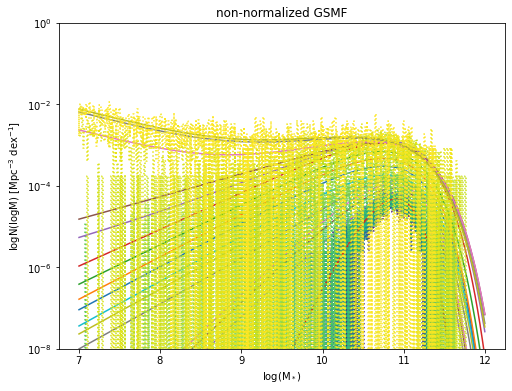

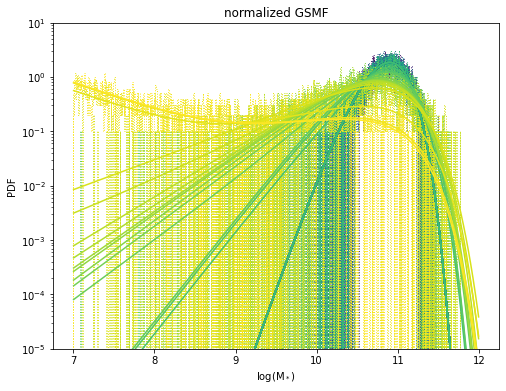

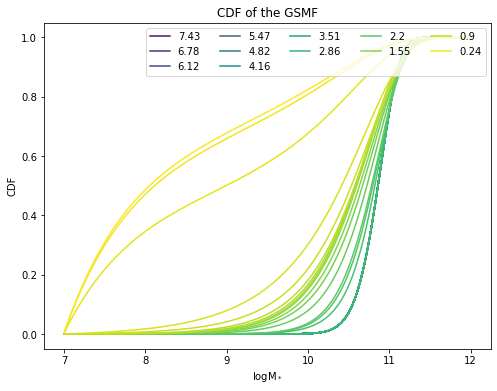

In [17]:
if passive_calc == True:
    
    if IMF == 'Kroupa_01':
        # in questo caso devo applicare il rescaling 
        delta_logM = 0.03
    
    logM_pass = np.zeros((len(z_mid), Nsample))
    logSFR_pass = np.zeros((len(z_mid), Nsample))
    logZ_pass = np.zeros((len(z_mid), Nsample))

    N_pass = np.zeros((len(z_mid), 2))

    # plot to make comparisons
    # creating  figures:
    f0 = plt.figure(figsize = (8,6))
    ax0 = f0.add_subplot(111)
    # normed GSMF and sampled masses
    f1 = plt.figure(figsize = (8,6))
    ax1 = f1.add_subplot(111)
    # CDF
    f2 = plt.figure(figsize = (8,6))
    ax2 = f2.add_subplot(111)

    # color map
    viridis = cm.get_cmap('viridis', len(z_mid))
    divid = np.linspace(0, 1, len(z_mid))
    color_z = viridis(divid)

    counter = 0

    for i in tqdm(range(len(z_mid))):

        #print('z = ', z_mid[i])

        dN_dV_NSFR = np.sum(GSMF_NSFR_interp(masses_NSFR_mid, z_mid[i])*masses_NSFR_delta)
        p_star_pass =  np.sum(10**masses_NSFR_mid*\
                          GSMF_NSFR_interp(masses_NSFR_mid, z_mid[i])*masses_NSFR_delta)
        #print('    Quiescent stellar mass density log \phi= ', np.log10(p_star_pass))
        p_star_tot =  np.sum(10**masses_NSFR_mid*\
                         GSMF_tot_interp(masses_NSFR_mid, z_mid[i])*masses_NSFR_delta)
        #print('    Total stellar mass density log \phi = ', np.log10(p_star_tot))
        #print('    fraction in stellar mass = ', p_star_pass/p_star_tot)


        # here I evaluate the total number of passive galaxies to be used at each merger redshift
        # V is the volume fixed while sampling the star forming galaxies 
        N_sample_NSF = int(V*dN_dV_NSFR)
        N_pass[i,0] = z_mid[i]
        N_pass[i,1] = N_sample_NSF
        #print('    sample of non star forming galaxies = ',N_sample_NSF)

        #print('    ratio with star forming galaxies in galaxy number = ', N_sample_NSF/Nsample)

        # I should now sample from the NON SFR GSMF 
        Masses_NSFR = np.zeros(Nsample)
        SFR_NSFR = np.zeros(Nsample)
        logZ_NSFR = np.zeros(Nsample)

        ax0.plot(masses_NSFR_mid,GSMF_NSFR_interp(masses_NSFR_mid, z_mid[i]))
        n_deltaMj = GSMF_NSFR_interp(masses_NSFR_mid, z_mid[i])/dN_dV_NSFR
        ax1.plot(masses_NSFR_mid, n_deltaMj, color = color_z[i]) 
        ### evaluating the CDF of the GSMF and plotting it 
        CDF_GSMF = np.cumsum(n_deltaMj*masses_NSFR_delta) 
        if counter == 3:
            ax2.plot(masses_NSFR_mid, CDF_GSMF, color = color_z[i], 
                     label = str(round(z_mid[i],2)))
            counter = 0
        else:
            ax2.plot(masses_NSFR_mid, CDF_GSMF, color = color_z[i])
            counter = counter + 1

        ### drawning Nsample random numbers
        coins = np.random.uniform(CDF_GSMF.min(),CDF_GSMF.max(),Nsample)
        inv_CDF = interp1d(CDF_GSMF,masses_NSFR_mid)
        mass_sampled = np.sort(inv_CDF(coins))
        Masses_NSFR = 10**(mass_sampled+delta_logM)

        ax1.hist(mass_sampled, mass_bins_plot, 
                 histtype = 'step', density = True,linestyle = ':', color = color_z[i]) 
        ### We want to check the normalization constant, i.e. the number of galaxy 
        ### per volume element. We plot this instogram against the GSMF
        check_const = np.histogram(mass_sampled, bins = mass_bins_plot,
                                   density = True)[0]*dN_dV_NSFR
        ax0.step(mass_bins_plot_mid, check_const, 
                linestyle = ':', color = color_z[i])

        # so here I sampled and saved the masses
        logM_pass[i,:] = Masses_NSFR

        for m in range(len(Masses_NSFR)):
            #print(SFR_max_here)

            #SFR_max_here = SFR_max_interp(z_mid[i],Masses_NSFR[m])

            ind_m = np.argmin(abs(Masses_NSFR[m] - mass_bin_for_sfr_mid))

            SFR_max_here = SFR_pass_max[i, ind_m]
            #print(SFR_max_here)
            SFR_min_here = SFR_pass_min[i, ind_m]
            #print(SFR_min_here)

            # the maximum SFR must depend on the mass
            SFR_NSFR[m] = np.random.uniform(SFR_min_here, 10**SFR_max_here)
            
            ### evaluating the metallicity of each given galaxy 
            if Metallicity_scaling_relation == 'FMR':
                FOH_sampled = FMR(np.log10(Masses_NSFR[m]), np.log10(SFR_NSFR[m]), delta_logM, K_IMF)
                ### converting in metallcity values
                Z_mean_sampled = np.log10(FOH2ZZ(FOH_sampled,solar_Z_scale))
                Z_sampled = np.random.normal(Z_mean_sampled, Z_spread_met_rel)
                ### you have to think more about this scatter
                
            elif Metallicity_scaling_relation == 'MZR':
                FOH_sampled = MZR(Masses_NSFR[m], z_mid[i], delta_logM, K_IMF)
                ### converting in metallcity values
                Z_mean_sampled = np.log10(FOH2ZZ(FOH_sampled,solar_Z_scale))
                Z_sampled = np.random.normal(Z_mean_sampled, 
                                     Z_spread_met_rel)
                
            ### you have to think more about this scatter
            logZ_NSFR[m] = Z_sampled
            #logZ_NSFR[m] = sampling_logZ(Masses_NSFR[m],
            #                            SFR_NSFR[m],
            #                            z_mid[i])

        logSFR_pass[i,:] = SFR_NSFR
        logZ_pass[i,:] = logZ_NSFR


    # various figure features
    ### non-normalized GSMF
    ax0.set_title('non-normalized GSMF')
    ax0.set_yscale('log')
    ax0.set_xlabel(r'log(M$_*$)')
    ax0.set_ylabel(r'logN(logM) [Mpc$^{-3}$ dex$^{-1}$]')
    ax0.set_ylim(bottom= 1e-8, top = 1)
    #ax0.legend(ncol = 5)
    if save_option == 'ON':
        ax0.figure.savefig(folder_all + 'Passive/non_normalizedGSMF_passive.pdf', format = 'pdf', bbox_inches='tight')
    ### normalized GSMF
    ax1.set_title('normalized GSMF')
    ax1.set_yscale('log')
    ax1.set_xlabel(r'log(M$_*$)')
    ax1.set_ylabel(r'PDF')
    ax1.set_ylim([1e-5,1e01])
    #ax1.legend(ncol = 5)
    if save_option == 'ON':
        ax1.figure.savefig(folder_all + 'Passive/normalizedGSMF_passive.pdf', format = 'pdf', bbox_inches='tight')
    ### CDF
    ax2.set_title('CDF of the GSMF')
    ax2.set_xlabel(r'logM$_*$')
    ax2.set_ylabel(r'CDF')
    ax2.legend(loc = 1, ncol = 5)
    if save_option == 'ON':
        ax2.figure.savefig(folder_all + 'Passive/GSMF_CDF_passive.pdf', format = 'pdf', bbox_inches='tight')

    plt.show()    
    plt.close()

number of passive galaxies =  106.0


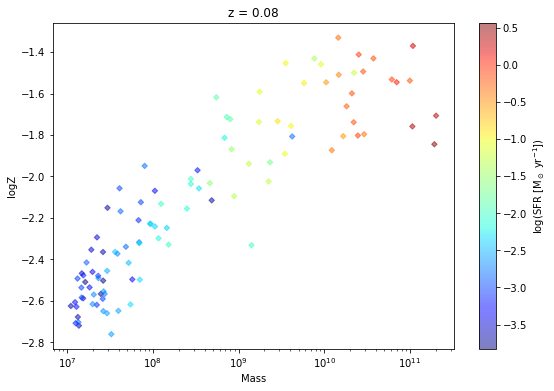

In [18]:
plt.figure(figsize=(9,6))

ind_z = len(z_mid)-1


# passive galaxies
ind_chosen = []
choices = np.arange(len(logM_pass[ind_z,:]))
print('number of passive galaxies = ', N_pass[ind_z,1])
for j in range(int(N_pass[ind_z,1])):
    ind = np.random.choice(choices)
    ind_chosen.append(ind)
    choices = choices[choices != ind]


# or ind_chosen
M_pass = logM_pass[ind_z,ind_chosen]
SFR_pass = np.log10(logSFR_pass[ind_z,ind_chosen])
Z_pass = logZ_pass[ind_z,ind_chosen]


plt.scatter(M_pass, Z_pass, c = SFR_pass , facecolor = "None", alpha = 0.5,
            s = 15, marker = 'D', cmap = plt.cm.jet )


plt.xscale('log')
#plt.yscale('log')

plt.xlabel('Mass')
plt.ylabel('logZ')

plt.colorbar(label = r'log(SFR [M$_\odot$ yr$^{-1}$])')

plt.title('z = '+str(round(z_mid[ind_z],2)))

if save_option == 'ON':
    plt.savefig(folder_all + 'Passive/Mass_logZ_SFR_dist.pdf', format = 'pdf', bbox_inches='tight')


plt.show()

number of passive galaxies =  106.0


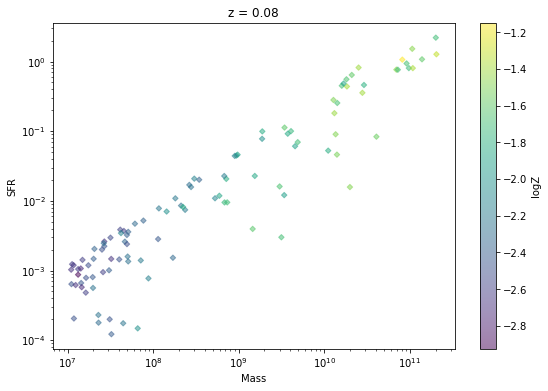

In [19]:
plt.figure(figsize=(9,6))

ind_z = len(z_mid)-1


# passive galaxies
ind_chosen = []
choices = np.arange(len(logM_pass[ind_z,:]))
print('number of passive galaxies = ', N_pass[ind_z,1])
for j in range(int(N_pass[ind_z,1])):
    ind = np.random.choice(choices)
    ind_chosen.append(ind)
    choices = choices[choices != ind]


M_pass = logM_pass[ind_z,ind_chosen]
SFR_pass = logSFR_pass[ind_z,ind_chosen]
Z_pass = logZ_pass[ind_z,ind_chosen]

plt.scatter(M_pass, SFR_pass, alpha = 0.5, c = Z_pass , 
            s = 15, marker = 'D', cmap = plt.cm.viridis)

plt.colorbar(label = r'logZ')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Mass')
plt.ylabel('SFR')

plt.title('z = '+str(round(z_mid[ind_z],2)))

if save_option == 'ON':
    plt.savefig(folder_all + 'Passive/Mass_SFR_logZ_dist.pdf', format = 'pdf', bbox_inches='tight')


plt.show()

redshift =  4.0
number of passive galaxies =  0.0


redshift =  1.0612244897959187
number of passive galaxies =  9.0


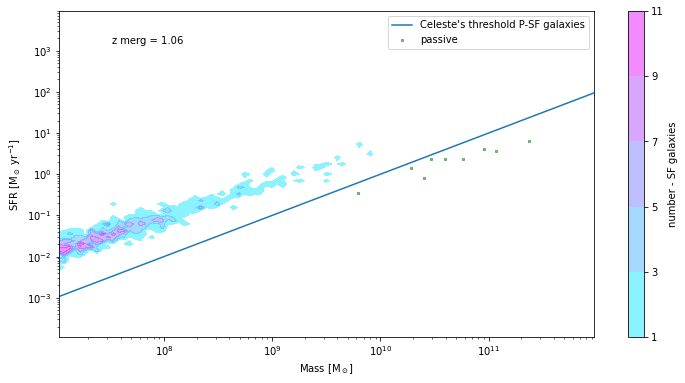

redshift =  0.08163265306122458
number of passive galaxies =  106.0


In [20]:
if passive_calc == True:
    # let's make the SFR-Mass plot

    mass_plot = np.logspace(7,12, 100)
    mass_plot_mid = mid_creator(mass_plot)
    sfr_plot = np.logspace(-4, 4, 100)
    sfr_plot_mid = mid_creator(sfr_plot)

    z_check = [4,1,0]

    for i in range(len(z_check)):
        ind_z = np.argmin(abs(z_mid-z_check[i]))
        print('redshift = ', z_mid[ind_z])

        fig = plt.figure(figsize=(12,6))
        
        plt.plot(mass_plot_mid, mass_plot_mid*1e-10, label = "Celeste's threshold P-SF galaxies")


        h_local = np.histogram2d(10**Mass_all[ind_z,:], 10**SFR_all[ind_z,:],
                             bins = [mass_plot,sfr_plot])[0]
        #print(h_local)
        
        
        cs2 = plt.contourf(mass_plot_mid,sfr_plot_mid, np.transpose(h_local), 
               cmap= 'cool', alpha = 0.5, 
               levels = np.arange(1,np.max(h_local, axis = None),2))


        # passive galaxies
        ind_chosen = []
        choices = np.arange(len(logM_pass[ind_z,:]))
        print('number of passive galaxies = ', N_pass[ind_z,1])
        for j in range(int(N_pass[ind_z,1])):
            ind = np.random.choice(choices)
            ind_chosen.append(ind)
            choices = choices[choices != ind]


        M_pass = logM_pass[ind_z,ind_chosen]
        SFR_pass = logSFR_pass[ind_z,ind_chosen]
        #print(M_pass, SFR_pass)
        plt.scatter(M_pass, SFR_pass, marker = 's', color = 'green', label = 'passive',
                   alpha = 0.5, s=2)
        """
        h_pass = np.histogram2d(M_pass, SFR_pass,
                             bins = [mass_plot,sfr_plot])[0]

        cs_pass = plt.contour(mass_plot_mid,sfr_plot_mid, np.transpose(h_pass), 
               cmap= 'Greens' #, alpha = 0.5, 
                #levels = np.arange(1,np.max(h_pass, axis = None),10)
                             )
        fig.colorbar(cs_pass,label = 'number - Passive galaxies' )
        """

        fig.colorbar(cs2,label = 'number - SF galaxies' )

        plt.xscale('log')
        plt.xlabel(r'Mass [M$_\odot$]')
        plt.ylabel(r'SFR [M$_\odot$ yr$^{-1}$]')
        plt.yscale('log')

        #plt.legend()

        plt.annotate('z merg = '+str(round(z_mid[ind_z],2)), xy = [0.1,0.9], xycoords = 'axes fraction')
        plt.legend()
        if save_option == 'ON':
            plt.savefig(folder_all_in_pass +'/Mass_SFR_all_'+\
                str(round(z_mid[ind_z],2))+'.png', format = 'png')

        plt.show()  


In [21]:
if save_option == 'ON':
    if passive_calc == True:
        # saving everything :) 
        np.savetxt(folder_all_in_pass+'/Passive_logM.txt', np.log10(logM_pass))
        np.savetxt(folder_all_in_pass+'/Passive_logSFR.txt', np.log10(logSFR_pass))
        np.savetxt(folder_all_in_pass+'/Passive_logZ.txt', logZ_pass)
        np.savetxt(folder_all_in_pass+'/Passive_N.txt', N_pass, header = 'Redshift Number_of_passive')


redshift =  4.0
number of passive galaxies =  0.0


/home/santoliquido/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


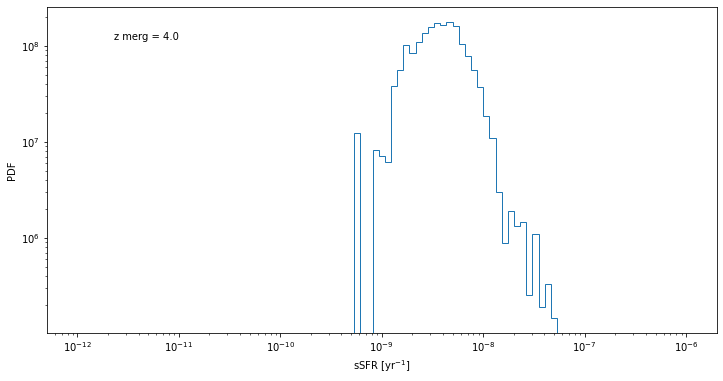

redshift =  1.0612244897959187
number of passive galaxies =  9.0


redshift =  0.08163265306122458
number of passive galaxies =  106.0


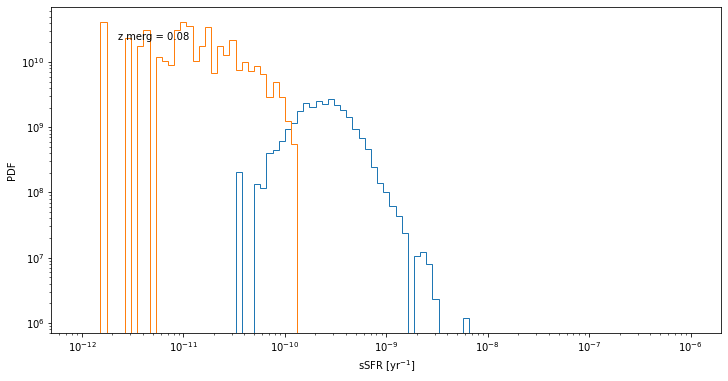

In [22]:
if passive_calc == True:
    # let's make the sSFR-Mass plot
    #mass_plot = np.logspace(7,12, 100)
    #mass_plot_mid = mid_creator(mass_plot)
    ssfr_plot = np.logspace(-12, -6, 100)
    ssfr_plot_mid = mid_creator(ssfr_plot)
    z_check = [4,1,0]
    for i in range(len(z_check)):
        ind_z = np.argmin(abs(z_mid-z_check[i]))
        print('redshift = ', z_mid[ind_z])

        fig = plt.figure(figsize=(12,6))
        
        plt.hist(10**SFR_all[ind_z,:]/10**Mass_all[ind_z,:], bins =ssfr_plot, 
                density = True,  histtype = 'step')

        # passive galaxies
        ind_chosen = []
        choices = np.arange(len(logM_pass[ind_z,:]))
        print('number of passive galaxies = ', N_pass[ind_z,1])
        for j in range(int(N_pass[ind_z,1])):
            ind = np.random.choice(choices)
            ind_chosen.append(ind)
            choices = choices[choices != ind]


        M_pass = logM_pass[ind_z,ind_chosen]
        SFR_pass = logSFR_pass[ind_z,ind_chosen]
        sSFR_pass = SFR_pass/M_pass
        plt.hist(sSFR_pass, bins = ssfr_plot, density = True,
                histtype = 'step')
        
        #fig.colorbar(cs2,label = 'number - SF galaxies' )

        plt.xscale('log')
        #plt.xlabel(r'Mass [M$_\odot$]')
        #plt.ylabel(r'sSFR [yr$^{-1}$]')
        plt.ylabel(r'PDF')
        plt.xlabel(r'sSFR [yr$^{-1}$]')
        plt.yscale('log')

        #plt.legend()

        plt.annotate('z merg = '+str(round(z_mid[ind_z],2)), xy = [0.1,0.9], xycoords = 'axes fraction')
        #plt.legend()
        
        #plt.ylim([min(ssfr_plot_mid),max(ssfr_plot_mid)])
        if save_option == 'ON':
            plt.savefig(folder_all_in_pass +'/Mass_sSFR_all_'+\
                str(round(z_mid[ind_z],2))+'.png', format = 'png')


        plt.show()  
